In [1]:
#import os
#os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.optimizers import Adam
#from keras import backend as K
from keras.datasets import cifar10

np.random.seed(1000)
## load the data
(X_train, y_train), (x_test, y_test) = cifar10.load_data()
X_train=X_train/255

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

Using TensorFlow backend.


In [11]:
######## buidling the two main components of the GAN, namely generator and discriminator
randomDim = 128
# Generator
generator = Sequential()
generator.add(Dense(128*8*8, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((8, 8, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(3, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(32,32, 3)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

In [17]:
### Train the model
epochs=3
batchSize=32
batch_number = X_train.shape[0] / batchSize

### training loop
for e in range(1, epochs+1):
    start_time_opoch = time.time()
    print ('-'*10, 'Satrt of the Epoch %d' % e, '-'*10)
    for i in range(int(batch_number)):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        # Generate some fake images and then concatenate them with real ones
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])
        yDis = np.zeros(2*batchSize)
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)
    print("Time Of the Execution of epoch %i = %s seconds ---" % (e,time.time() - start_time_opoch))

---------- Satrt of the Epoch 1 ----------
Time Of the Execution of epoch 1 = 71.44901323318481 seconds ---
---------- Satrt of the Epoch 2 ----------
Time Of the Execution of epoch 2 = 81.52395582199097 seconds ---
---------- Satrt of the Epoch 3 ----------
Time Of the Execution of epoch 3 = 81.88703751564026 seconds ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


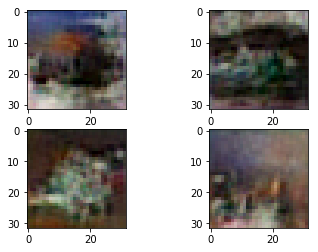

In [20]:
### have the GAN generate some new images and then display them

noise = np.random.uniform(-1.0, 1.0, size=[4, 128])
images_fake = generator.predict(noise)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images_fake[i])
